### Use M1 to calculate the validation stats



In [1]:
require('rstan')
require('tidyverse')
options(stringsAsFactors=FALSE)

Loading required package: rstan
Loading required package: ggplot2
Loading required package: StanHeaders
rstan (Version 2.17.3, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  1.4.2     ✔ purrr   0.2.4
✔ tidyr   0.8.1     ✔ dplyr   0.7.4
✔ readr   1.1.1     ✔ stringr 1.3.0
✔ tibble  1.4.2     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract() masks rstan::extract()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()


In [2]:
createCompareDf <- function(trait){
    m_v <- read_tsv(sprintf("../gwas_valid/ukb24983_v2_hg19.%s_onesex.genotyped.glm.linear", trait) ) 
    f_v <- read_tsv(sprintf("../gwas_valid/ukb24983_v2_hg19.%s_zerosex.genotyped.glm.linear", trait))

    
    df_t_train <- read.table(sprintf("../data/1020/m2/snps4_%s.txt", trait), sep=" ", header=TRUE); 
    m_train <- df_t_train %>% filter(category==3) %>% select( -p1, -p2, -p4, -category) %>% rename(post=p3, ID=SNP)
    f_train <- df_t_train %>% filter(category==2) %>% select( -p1, -p3, -p4, -category)%>% rename(post=p2, ID=SNP)
    
    test_valid <- cbind( (f_v %>% select(`#CHROM`, BETA, SE, P) %>% rename(CHR=`#CHROM`, B.f=BETA, SE.f=SE, P.f=P)),
        (m_v %>% select(ID, POS, REF, ALT, BETA, SE, P) %>% rename(B.m=BETA, SE.m=SE, P.m=P)))

    test_valid_filt <- test_valid %>% filter(ID %in% c(f_train$ID, m_train$ID)) %>% 
    mutate(sex=ifelse(ID %in% f_train$ID, "female", "male"), dataset="validation")

    test_valid_filt2 <- test_valid_filt %>% select(-POS, -REF, -ALT)
    test_disc <- rbind(f_train %>% mutate(sex="female"), m_train %>% mutate(sex="male")) %>% mutate(dataset="discovery")


    test_valid_filt3 <- test_valid_filt2 %>% 
    rename(B.f.v=B.f, B.m.v=B.m, SE.f.v=SE.f, SE.m.v=SE.m, P.f.v=P.f, P.m.v=P.m) %>% 
    select(-dataset) 

    train_valid_compare <- full_join(test_disc %>% select(-sex, -dataset), test_valid_filt3 %>% select( -CHR), by="ID")
    return(train_valid_compare)
}




In [20]:


getGenCorr <- function(B, SE){
    dat <- list("K"=2, "M"=2, "N"=nrow(B), "B"=B, "SE"=SE)
    options(mc.cores = parallel::detectCores())
    rstan_options(auto_write = TRUE)
    fit1 <- stan(file = "../mixture_model_scripts/models/model1_no_loglik.stan",  
            data = dat,    
            chains = 4, warmup = 1000, iter = 2000, cores = 4, refresh = 200)
    return(summary(fit1)$summary["Omegacor[1,2]", c("mean", "se_mean", "sd", "50%", "Rhat")])
}



In [22]:
getRg <- function(compare_df){
    
    # for f vars:
    f.vars <- compare_df %>% filter(sex=="female")
      # b_f, b_f_v
      B_FF <- cbind(f.vars$B.f, f.vars$B.f.v)
      SE_FF <- cbind(f.vars$SE.f, f.vars$SE.f.v)
    g1 <- getGenCorr(B_FF, SE_FF)
      # b_m, b_m_v
      B_FM <- cbind(f.vars$B.m, f.vars$B.m.v)
      SE_FM <- cbind(f.vars$SE.m, f.vars$SE.m.v)    
        g2 <- getGenCorr(B_FM, SE_FM)

    # for m vars:
    m.vars <- compare_df %>% filter(sex=="male")
      # b_f, b_f_v
      B_MF <- cbind(f.vars$B.f, f.vars$B.f.v)
      SE_MF <- cbind(f.vars$SE.f, f.vars$SE.f.v)
            g3 <- getGenCorr(B_MF, SE_MF)

      # b_m, b_m_v
      B_MM <- cbind(f.vars$B.m, f.vars$B.m.v)
      SE_MM <- cbind(f.vars$SE.m, f.vars$SE.m.v)    
            g4 <- getGenCorr(B_MM, SE_MM)
    return(list(g1, g2, g3, g4))
   
}

In [19]:
testosterone_valid <- createCompareDf("Testosterone")


Parsed with column specification:
cols(
  `#CHROM` = col_character(),
  POS = col_integer(),
  ID = col_character(),
  REF = col_character(),
  ALT = col_character(),
  A1 = col_character(),
  TEST = col_character(),
  OBS_CT = col_integer(),
  BETA = col_double(),
  SE = col_double(),
  T_STAT = col_double(),
  P = col_double()
)
Parsed with column specification:
cols(
  `#CHROM` = col_character(),
  POS = col_integer(),
  ID = col_character(),
  REF = col_character(),
  ALT = col_character(),
  A1 = col_character(),
  TEST = col_character(),
  OBS_CT = col_integer(),
  BETA = col_double(),
  SE = col_double(),
  T_STAT = col_double(),
  P = col_double()
)


ERROR: Error in getGenCorr(B_FF, SE_FF): object 'SE' not found


In [23]:
res <- getRg(testosterone_valid)

Inference for Stan model: model1_no_loglik.
4 chains, each with iter=600; warmup=200; thin=1; 
post-warmup draws per chain=400, total post-warmup draws=1600.

                 mean se_mean      sd     2.5%     50%   97.5% n_eff    Rhat
Sigma[1,1]    0.00107 0.00000 0.00006  0.00095 0.00106 0.00120  1015 0.99948
Sigma[1,2]    0.00027 0.00001 0.00022 -0.00003 0.00026 0.00072   518 1.00702
Sigma[2,1]    0.00027 0.00001 0.00022 -0.00003 0.00026 0.00072   518 1.00702
Sigma[2,2]    0.00017 0.00001 0.00017  0.00000 0.00012 0.00062   707 1.00392
pi[1]         0.00127 0.00004 0.00121  0.00004 0.00092 0.00451   987 1.00358
pi[2]         0.99873 0.00004 0.00121  0.99549 0.99908 0.99996   987 1.00358
Omegacor[1,1] 1.00000 0.00000 0.00000  1.00000 1.00000 1.00000  1600     NaN
Omegacor[1,2] 0.61736 0.01599 0.35712 -0.37909 0.73707 0.97375   499 1.00230
Omegacor[2,1] 0.61736 0.01599 0.35712 -0.37909 0.73707 0.97375   499 1.00230
Omegacor[2,2] 1.00000 0.00000 0.00000  1.00000 1.00000 1.00000  1592 0.

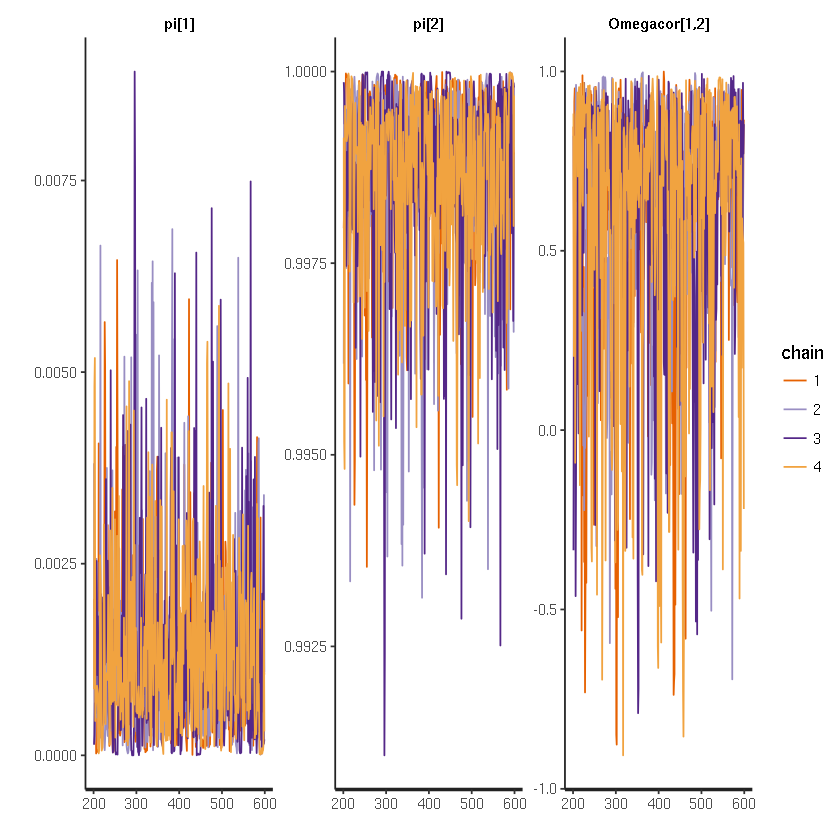

In [11]:
print(fit1, pars=c("Sigma", "pi", "Omegacor"), probs=c(0.025, 0.5, 0.975), digits_summary=5)
traceplot(fit1, pars=c("pi", "Omegacor[1,2]"))

In [26]:
save(res, file="genCorr1024.RData")

In [12]:
  rstan_options(auto_write = TRUE)
    fit1 <- stan(file = "../mixture_model_scripts/models/model1_no_loglik.stan",  
            data = dat,    
            chains = 4, warmup = 1000, iter = 2000, cores = 4, refresh = 200)

Inference for Stan model: model1_no_loglik.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                 mean se_mean      sd     2.5%     50%   97.5% n_eff    Rhat
Sigma[1,1]    0.00107 0.00000 0.00006  0.00095 0.00107 0.00119  3054 1.00048
Sigma[1,2]    0.00024 0.00000 0.00021 -0.00003 0.00022 0.00071  1960 1.00099
Sigma[2,1]    0.00024 0.00000 0.00021 -0.00003 0.00022 0.00071  1960 1.00099
Sigma[2,2]    0.00015 0.00000 0.00016  0.00000 0.00010 0.00058  2638 1.00078
pi[1]         0.00125 0.00002 0.00126  0.00003 0.00087 0.00454  3344 1.00106
pi[2]         0.99875 0.00002 0.00126  0.99546 0.99913 0.99997  3344 1.00106
Omegacor[1,1] 1.00000 0.00000 0.00000  1.00000 1.00000 1.00000  4000     NaN
Omegacor[1,2] 0.57597 0.00929 0.37592 -0.43958 0.70144 0.96951  1638 1.00019
Omegacor[2,1] 0.57597 0.00929 0.37592 -0.43958 0.70144 0.96951  1638 1.00019
Omegacor[2,2] 1.00000 0.00000 0.00000  1.00000 1.00000 1.00000  3908

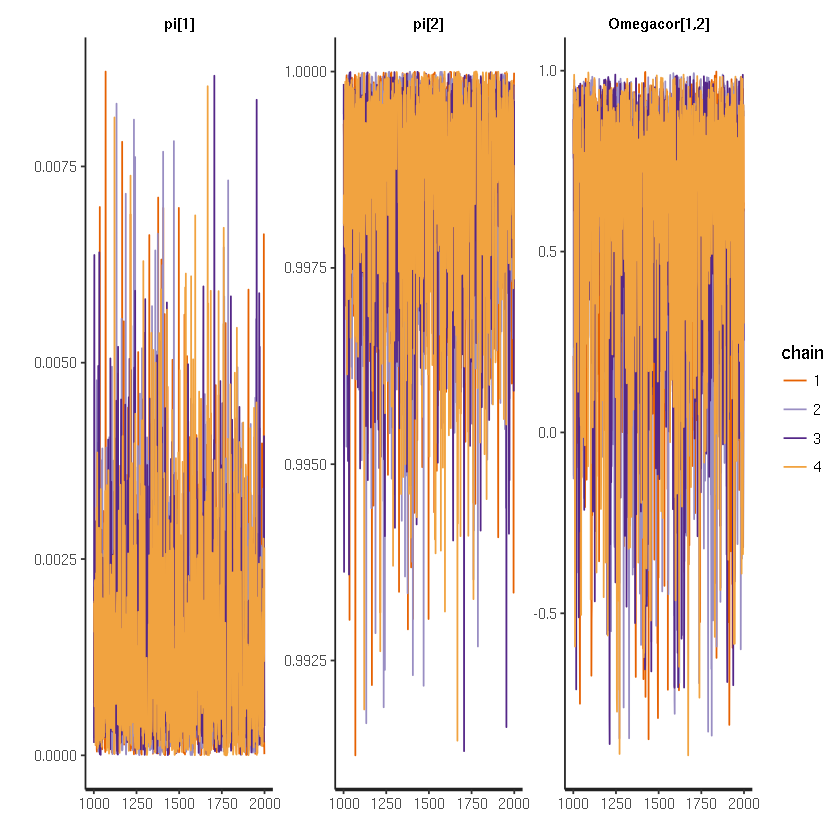

In [13]:
print(fit1, pars=c("Sigma", "pi", "Omegacor"), probs=c(0.025, 0.5, 0.975), digits_summary=5)
traceplot(fit1, pars=c("pi", "Omegacor[1,2]"))